Import, Setup, Paths

In [42]:
%pip install torch torchvision torchaudio pandas matplotlib seaborn scikit-learn tqdm fastparquet

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision.models as models

Note: you may need to restart the kernel to use updated packages.


In [43]:
# Path di base
DATA_PATH = 'data/raw/visuelle2'

df_sales = pd.read_csv(os.path.join(DATA_PATH, 'sales.csv'))
df_price = pd.read_csv(os.path.join(DATA_PATH, 'price_discount_series.csv'))
df_meteo = pd.read_csv(os.path.join(DATA_PATH, 'vis2_weather_data.csv'))
df_trends = pd.read_csv(os.path.join(DATA_PATH, 'vis2_gtrends_data.csv'))
df_restocks = pd.read_csv(os.path.join(DATA_PATH, 'restocks.csv'))

#### Caricamento labels & label encoding

In [44]:
# Carica mapping numerici (label encoding)
category_labels = torch.load(os.path.join(DATA_PATH, 'category_labels.pt'))
color_labels    = torch.load(os.path.join(DATA_PATH, 'color_labels.pt'))
fabric_labels   = torch.load(os.path.join(DATA_PATH, 'fabric_labels.pt'))

cat2idx  = {k: v for k, v in category_labels.items()}
col2idx  = {k: v for k, v in color_labels.items()}
fab2idx  = {k: v for k, v in fabric_labels.items()}

#### Wide → Long: Vendite settimanali

In [45]:
week_cols = [str(i) for i in range(12)]
df_long = pd.melt(
    df_sales,
    id_vars=[c for c in df_sales.columns if c not in week_cols],
    value_vars=week_cols,
    var_name='week',
    value_name='sales'
)
df_long['week'] = df_long['week'].astype(int)
df_long

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,week,sales
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,0,1.0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,0,1.0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,0,1.0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,0,1.0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1282195,106845,5504,51,AW19,medium coat,grey,AI19/05504.png,foam rubber,2019-12-30,12,11,0.0
1282196,106846,5558,10,AW19,medium coat,black,AI19/05558.png,foam rubber,2019-12-30,12,11,0.0
1282197,106847,4988,108,AW19,medium coat,black,AI19/04988.png,cloth,2019-12-30,15,11,0.0
1282198,106848,4280,105,AW19,culottes,blue,AI19/04280.png,light jeans,2019-12-30,1,11,0.0


#### Aggiungi One-Hot delle Categorie/Colori/Fabbricati

In [46]:
df_long['cat_idx']    = df_long['category'].map(cat2idx)
df_long['color_idx']  = df_long['color'].map(col2idx)
df_long['fabric_idx'] = df_long['fabric'].map(fab2idx)
df_long

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,week,sales,cat_idx,color_idx,fabric_idx
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,0,1.0,3,0,7
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,0,1.0,3,8,7
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,0,1.0,3,0,7
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,0,1.0,0,6,16
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,0,1.0,3,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282195,106845,5504,51,AW19,medium coat,grey,AI19/05504.png,foam rubber,2019-12-30,12,11,0.0,4,0,24
1282196,106846,5558,10,AW19,medium coat,black,AI19/05558.png,foam rubber,2019-12-30,12,11,0.0,4,2,24
1282197,106847,4988,108,AW19,medium coat,black,AI19/04988.png,cloth,2019-12-30,15,11,0.0,4,2,4
1282198,106848,4280,105,AW19,culottes,blue,AI19/04280.png,light jeans,2019-12-30,1,11,0.0,0,7,27


#### Immagini: estrai embedding UNA sola volta e joinna

In [47]:
IMG_BASE = os.path.join(DATA_PATH, 'images')

cnn = models.resnet18(weights='IMAGENET1K_V1').eval()
layer = torch.nn.Sequential(*list(cnn.children())[:-1])
transf = T.Compose([
    T.Resize((224,224)), T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

prods_imgs = df_long.drop_duplicates('external_code')[['external_code', 'image_path']].dropna()
img_emb_dict = {}

for _, row in tqdm(prods_imgs.iterrows(), total=len(prods_imgs)):
    prod = row['external_code']
    img_path = os.path.join(IMG_BASE, row['image_path'])
    try:
        im = Image.open(img_path).convert('RGB')
        t = transf(im).unsqueeze(0)
        with torch.no_grad():
            emb = layer(t).squeeze().numpy().flatten()
        img_emb_dict[prod] = emb
    except Exception as e:
        img_emb_dict[prod] = np.zeros(512)
        print(f"ERRORE {img_path}: {e}")

for i in range(512):
    df_long[f'img_emb_{i}'] = df_long['external_code'].map(lambda p: img_emb_dict.get(p, np.zeros(512))[i])

 84%|████████▎ | 4477/5355 [02:05<00:28, 31.18it/s]

ERRORE data/raw/visuelle2/images/AI19/04442.png: unrecognized data stream contents when reading image file


100%|██████████| 5355/5355 [02:31<00:00, 35.41it/s]
/var/folders/tc/y68ss1d508g5s83sx4mrflf80000gq/T/ipykernel_61566/3834197450.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[f'img_emb_{i}'] = df_long['external_code'].map(lambda p: img_emb_dict.get(p, np.zeros(512))[i])
/var/folders/tc/y68ss1d508g5s83sx4mrflf80000gq/T/ipykernel_61566/3834197450.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[f'img_emb_{i}'] = df_long['external_code'].map(lambda p: img_emb_dict.get(p, np.zeros(512))[i])
/var/folders/tc/

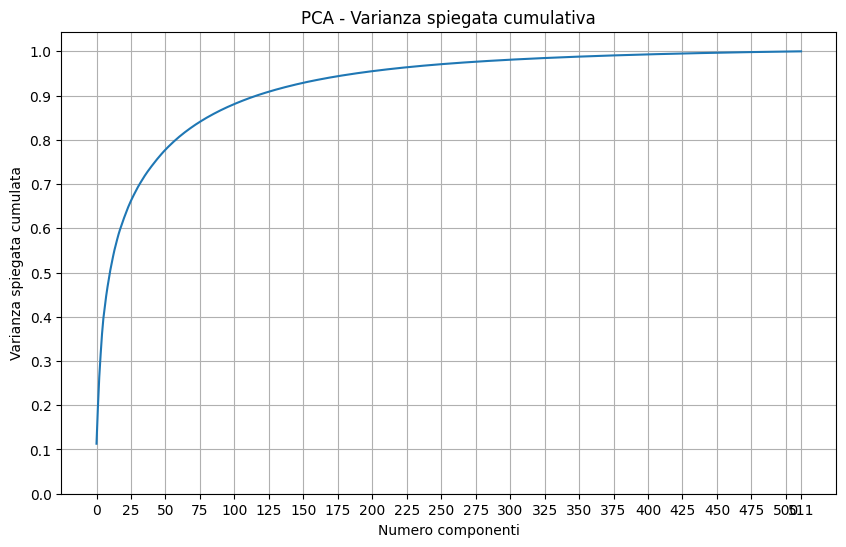

In [48]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

emb_cols = [c for c in df_long.columns if c.startswith("img_emb_")]
pca = PCA().fit(df_long[emb_cols].values)
expl_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(expl_var)
plt.xlabel('Numero componenti')
plt.ylabel('Varianza spiegata cumulata')

# Label ogni 25 componenti sull'asse X
num_components = len(expl_var)
tick_positions_x = list(range(0, num_components, 25)) + [num_components - 1]
plt.xticks(tick_positions_x)

# Label ogni 0.1 sull'asse Y
tick_positions_y = np.arange(0.0, 1.01, 0.1)
plt.yticks(tick_positions_y)

plt.grid(True)
plt.title("PCA - Varianza spiegata cumulativa")
plt.show()


#### PCA

In [49]:
# 1. Trova i nomi delle colonne degli embeddings
emb_cols = [c for c in df_long.columns if c.startswith("img_emb_")]

# 2. Fai la PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
img_pca = pca.fit_transform(df_long[emb_cols].values)

# 3. Aggiungi le colonne PCA al dataframe
for i in range(img_pca.shape[1]):
    df_long[f'img_pca_{i}'] = img_pca[:, i]

# 4. Drop delle colonne embedding originali
df_long = df_long.drop(columns=emb_cols)

/var/folders/tc/y68ss1d508g5s83sx4mrflf80000gq/T/ipykernel_61566/3396063709.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[f'img_pca_{i}'] = img_pca[:, i]
/var/folders/tc/y68ss1d508g5s83sx4mrflf80000gq/T/ipykernel_61566/3396063709.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_long[f'img_pca_{i}'] = img_pca[:, i]
/var/folders/tc/y68ss1d508g5s83sx4mrflf80000gq/T/ipykernel_61566/3396063709.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many ti

#### RESTOCK: join per product-negozio-week

In [50]:
# Adattare se serve anche per 'year'; qui chiavi semplici:
df_restocks.rename(columns={'qty':'restock_qty'}, inplace=True)
join_key = ['external_code','retail','week']
if 'year' in df_restocks.columns and 'year' in df_long.columns:
    join_key.append('year')
df_long = df_long.merge(
    df_restocks[join_key + ['restock_qty']],
    on=join_key, how='left'
)
df_long['restock_qty'] = df_long['restock_qty'].fillna(0)
df_long

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,img_pca_91,img_pca_92,img_pca_93,img_pca_94,img_pca_95,img_pca_96,img_pca_97,img_pca_98,img_pca_99,restock_qty
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,-0.217840,0.850164,0.642322,1.105982,-0.311769,0.196899,-0.150576,-0.106466,0.698639,0.0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,-0.786835,-0.267178,0.083758,-0.360416,0.868162,-0.140389,-1.308113,0.355531,0.192572,0.0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,-0.217840,0.850164,0.642322,1.105982,-0.311769,0.196899,-0.150576,-0.106466,0.698639,0.0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,-0.249154,0.791264,0.212098,1.198878,0.121922,-1.055997,-0.236273,-0.402558,-0.097308,0.0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,-0.217840,0.850164,0.642322,1.105982,-0.311769,0.196899,-0.150576,-0.106466,0.698639,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282599,106845,5504,51,AW19,medium coat,grey,AI19/05504.png,foam rubber,2019-12-30,12,...,-0.058080,-0.087056,-0.030266,-0.441447,1.068755,0.327512,-0.075216,-0.310391,0.506103,0.0
1282600,106846,5558,10,AW19,medium coat,black,AI19/05558.png,foam rubber,2019-12-30,12,...,-0.163943,-0.342867,-0.663331,0.232808,0.557208,-0.215071,-0.517703,0.079223,0.717867,0.0
1282601,106847,4988,108,AW19,medium coat,black,AI19/04988.png,cloth,2019-12-30,15,...,0.065300,0.192258,-0.552493,-0.588600,-0.127144,0.199285,-0.410136,-0.280203,0.151023,0.0
1282602,106848,4280,105,AW19,culottes,blue,AI19/04280.png,light jeans,2019-12-30,1,...,1.337027,0.535079,-0.247520,-0.100493,-0.061103,1.284562,-0.937770,1.592560,1.245053,0.0


#### Altri join temporali: (prezzo, sconto, meteo, trends)

In [51]:
# Price/discount
df_price_long = pd.melt(
    df_price,
    id_vars=['external_code','retail','price'],
    value_vars=[str(i) for i in range(12)],
    var_name='week', value_name='discount'
)
df_price_long['week'] = df_price_long['week'].astype(int)

df_long = df_long.merge(
    df_price_long[['external_code','retail','week','price','discount']],
    on=['external_code','retail','week'], how='left'
)

# Meteo
shop_weather_pairs = torch.load(os.path.join(DATA_PATH, 'shop_weather_pairs.pt'))
shop2loc = {k: v for k, v in shop_weather_pairs.items() if v is not None}
df_long['locality'] = df_long['retail'].map(shop2loc)
df_long['release_date'] = pd.to_datetime(df_long['release_date'], errors='coerce')
df_meteo['date'] = pd.to_datetime(df_meteo['date'], errors='coerce')
df_long['week_date'] = df_long['release_date'] + pd.to_timedelta(df_long['week'], "W")

df_long = df_long.merge(
    df_meteo,
    left_on=['locality','week_date'],
    right_on=['locality','date'],
    how='left',
    suffixes=('', '_meteo')
)

# Trends
df_trends['date'] = pd.to_datetime(df_trends['date'], errors='coerce')
df_trends_renamed = df_trends.rename(
    columns={col: f"{col}_trend" for col in df_trends.columns if col not in ["date"]}
)
df_long = df_long.merge(
    df_trends_renamed,
    left_on='week_date',
    right_on='date',
    how='left'
)

df_long

,Unnamed: 0,external_code,retail,season,category,color,image_path,fabric,release_date,restock,...,scottish_trend,milano stitch_trend,devore_trend,hron_trend,ottoman_trend,fluid_trend,flamed_trend,fluid polyviscous_trend,shiny jersey_trend,goose_trend
0,0,5,36,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,22,...,60.0,0.0,27.0,14.0,71.0,80.0,33.0,-1.0,0.0,49.0
1,1,2,51,SS17,long sleeve,violet,PE17/00002.png,acrylic,2016-11-28,17,...,60.0,0.0,27.0,14.0,71.0,80.0,33.0,-1.0,0.0,49.0
2,2,5,10,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,15,...,60.0,0.0,27.0,14.0,71.0,80.0,33.0,-1.0,0.0,49.0
3,3,9,41,SS17,culottes,yellow,PE17/00009.png,scuba crepe,2016-11-28,32,...,60.0,0.0,27.0,14.0,71.0,80.0,33.0,-1.0,0.0,49.0
4,4,5,13,SS17,long sleeve,grey,PE17/00005.png,acrylic,2016-11-28,26,...,60.0,0.0,27.0,14.0,71.0,80.0,33.0,-1.0,0.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282599,106845,5504,51,AW19,medium coat,grey,AI19/05504.png,foam rubber,2019-12-30,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282600,106846,5558,10,AW19,medium coat,black,AI19/05558.png,foam rubber,2019-12-30,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282601,106847,4988,108,AW19,medium coat,black,AI19/04988.png,cloth,2019-12-30,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282602,106848,4280,105,AW19,culottes,blue,AI19/04280.png,light jeans,2019-12-30,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Aggiunta colonna time_idx e scelta target

In [52]:
# Forecast nel tempo per ogni (external_code, retail)
# Tipicamente: target = vendite

# Crea time_idx: numero progressivo di settimana per ogni prodotto-negozio
df_long = df_long.sort_values(['external_code', 'retail', 'release_date', 'week'])

# Calcolare time_idx globale oppure locale per serie:
# Esempio: time_idx = progressivo (week) per ogni (external_code, retail)
df_long['time_idx'] = (
    df_long.groupby(['external_code', 'retail'])['week'].rank(method='first').astype(int)
)


# Target finale:
df_long['target'] = df_long['sales']

# Visualizza un sample e salva
print(df_long[['external_code','retail','week','time_idx','target','cat_idx','color_idx','fabric_idx']].head())

df_long.to_parquet("long_table_multimodal_labelencoded_timeidx.parquet", index=False)

        external_code  retail  week  time_idx  target  cat_idx  color_idx  \
133                 1       3     0         1     3.0        3          8   
106983              1       3     1         2     3.0        3          8   
214094              1       3     2         3     1.0        3          8   
321012              1       3     3         4     4.0        3          8   
427879              1       3     4         5     3.0        3          8   

        fabric_idx  
133              7  
106983           7  
214094           7  
321012           7  
427879           7  


TO-DO:

1. Applicare PCA sui 512 embeddings e ridurli a 20–50 dimensioni (es. img_pca_0, ..., img_pca_49).

2. Aggiungere solo questi al tuo tabellare.

3. Testare il modello in PyTorch Forecasting con e senza embeddings per valutare l’impatto reale.